In [1]:
import dask.dataframe as dd 
import numpy as np
from sklearn.preprocessing import LabelEncoder,RobustScaler
from sklearn.metrics import f1_score, confusion_matrix, classification_report,accuracy_score,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc
import seaborn as sns
from collections import Counter
from ctgan import CTGANSynthesizer
from ctgan import load_demo
import warnings
from utils import *
warnings.filterwarnings('ignore')

In [2]:
data=dd.read_csv("../data/application_train.csv").compute()
print(data.shape)

(307511, 122)


In [3]:
data=cleaning(data)

Mem. usage decreased to 94.72 Mb (67.2% reduction)


In [4]:
categorical=data.select_dtypes('object').columns 

In [ ]:
# model = CTGANSynthesizer()
# model.fit(data)

In [124]:
# samples = model.sample(1000)

In [126]:
# for i in categorical:
#     lc=LabelEncoder()
#     data[i]=lc.fit_transform(data[i])

In [5]:
data=dd.get_dummies(data,drop_first=True)

In [6]:
cor_matrix = data.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
data.drop(to_drop,axis=1,inplace=True)

In [7]:
numeric=list(data.select_dtypes('float64').columns.values) +list(data.select_dtypes('float16').columns.values) + list(data.select_dtypes('int32').columns.values)+ list(data.select_dtypes('int16').columns.values)+ list(data.select_dtypes('int8').columns.values)+list(data.select_dtypes('float32').columns.values)

In [8]:
data.shape

(307511, 191)

In [9]:
for i in numeric :
    if i not in categorical:
        rs=RobustScaler()
        data[i]=rs.fit_transform(data[[i]])

In [10]:
def preprocessing(df):
    
    X = df.drop(['TARGET'], axis=1)
    y = df['TARGET']

    return X, y

In [11]:
def evaluationClassification(model):
    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print("accuracy",accuracy_score(y_test, y_pred))
    a,b,threshold=roc_curve(y_test,y_pred)
    auc_pred=auc(a,b)
    print("auc ",auc_pred)
    print("roc_auc_score ",roc_auc_score(y_test, y_pred))
    print("f1 score : " ,f1_score(y_test, y_pred))
    plt.title('ROC curve')
    plt.plot(a,b)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid()
    plt.legend()
    plt.show()


In [12]:
def evaluationClassificationThreshold(model,threshold):
    model.fit(X_train, y_train)
    y_pred=model.predict_proba(X_test)

    y_pred= (y_pred [:,1]>= 0.2).astype('int') 


    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print("accuracy",accuracy_score(y_test, y_pred))
    a,b,threshold=roc_curve(y_test,y_pred)
    auc_pred=auc(a,b)
    print("auc ",auc_pred)
    print("roc_auc_score ",roc_auc_score(y_test, y_pred))
    print("f1 score : " ,f1_score(y_test, y_pred))
    plt.plot(a,b)
    plt.show()


In [13]:
def BestThreshold(rf_model):
    step_factor = 0.05 
    threshold_value = 0.2 
    roc_score=0
    predicted_proba = rf_model.predict_proba(X_test)
    while threshold_value <=0.8: 
        temp_thresh = threshold_value
        predicted = (predicted_proba [:,1] >= temp_thresh).astype('int') 
        print('Threshold',temp_thresh,'--',roc_auc_score(y_test, predicted))
        if roc_score<roc_auc_score(y_test, predicted): 
            roc_score = roc_auc_score(y_test, predicted)
            thrsh_score = threshold_value
        threshold_value = threshold_value + step_factor
    print('---Optimum Threshold ---',thrsh_score,'--ROC--',roc_score)

<h1>Regression logistique</h1>

In [11]:
data_lr=data.copy()

In [13]:
from sklearn.linear_model import LogisticRegression


In [14]:
model=LogisticRegression()

In [15]:
X,y=preprocessing(data_lr)
X_train, X_test, y_train ,y_test =train_test_split(X,y,test_size=0.2,random_state=2)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56550
           1       0.00      0.00      0.00      4953

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503

[[56550     0]
 [ 4953     0]]
accuracy 0.9194673430564363
0.9194673430564363
auc  0.5


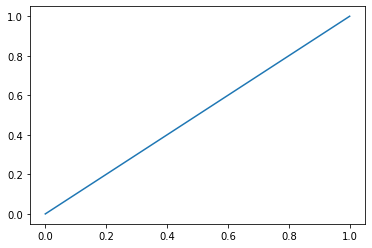

In [16]:
evaluationClassification(model)

In [17]:
import statsmodels.api as sm

In [18]:
log_reg = sm.Logit(y_train, X_train).fit()

         Current function value: 0.251369
         Iterations: 35


c:\Users\Ahmed\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [19]:
l=[]
b=[]
j=0
for i in log_reg.conf_int().index:
    if(log_reg.pvalues[i]>0.05):
        j+=1
        l.append(i)
        b.append(i)

In [ ]:
log_reg.summary()

* On Supprime les colonnes dont P>|z|	 > 0.05

In [21]:
X.drop(l,inplace=True,axis=1)

In [22]:
X.shape

(307511, 57)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56550
           1       0.00      0.00      0.00      4953

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503

[[56550     0]
 [ 4953     0]]
accuracy 0.9194673430564363
0.9194673430564363
auc  0.5


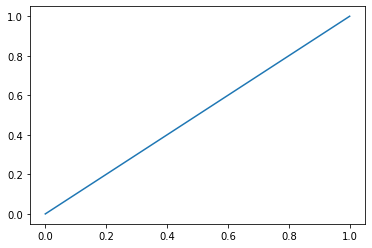

In [23]:
model=LogisticRegression()
X_train, X_test, y_train ,y_test =train_test_split(X,y,test_size=0.2,random_state=2)
evaluationClassification(model)

In [24]:
log_reg = sm.Logit(y, X).fit()

Optimization terminated successfully.
         Current function value: 0.252990
         Iterations 8


In [25]:
l=[]
j=0
for i in log_reg.conf_int().index:
    if(log_reg.pvalues[i]>0.05):
        j+=1
        l.append(i)
        b.append(i)

In [26]:
X.drop(l,inplace=True,axis=1)
X.shape

(307511, 48)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56550
           1       0.00      0.00      0.00      4953

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503

[[56550     0]
 [ 4953     0]]
accuracy 0.9194673430564363
0.9194673430564363
auc  0.5


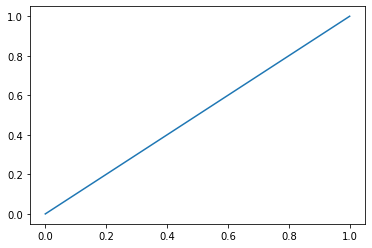

In [27]:
X_train, X_test, y_train ,y_test =train_test_split(X,y,test_size=0.2,random_state=2)
evaluationClassification(model)

In [28]:
log_reg = sm.Logit(y, X).fit()

Optimization terminated successfully.
         Current function value: 0.253121
         Iterations 8


In [29]:
l=[]
j=0
for i in log_reg.conf_int().index:
    if(log_reg.pvalues[i]>0.05):
        j+=1
        l.append(i)
        b.append(i)

In [30]:
l

[]

In [31]:
# X,y=preprocessing(data)
# X_train, X_test, y_train ,y_test =train_test_split(X,y,test_size=0.2,random_state=2)

In [32]:
counter = Counter(y_train)
counter

Counter({0: 226136, 1: 19872})

In [33]:
risque=data_lr[data_lr["TARGET"]==1]
non_risque=data_lr[data_lr["TARGET"]==0].sample(n=24825)

In [34]:
new=dd.concat([risque,non_risque]).compute()
new.shape

(49650, 189)

In [35]:
X,y=preprocessing(new)
X_train, X_test, y_train ,y_test =train_test_split(X,y,test_size=0.2,random_state=2)

              precision    recall  f1-score   support

           0       0.55      0.59      0.57      5008
           1       0.55      0.51      0.53      4922

    accuracy                           0.55      9930
   macro avg       0.55      0.55      0.55      9930
weighted avg       0.55      0.55      0.55      9930

[[2976 2032]
 [2388 2534]]
accuracy 0.5548841893252769
0.5548841893252769
auc  0.5545402853200017


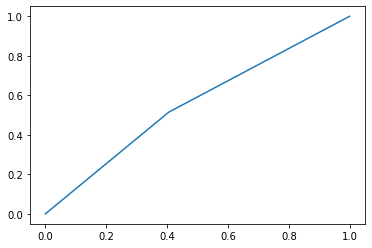

In [36]:
model=LogisticRegression()
evaluationClassification(model)

              precision    recall  f1-score   support

           0       0.56      0.63      0.59      5008
           1       0.57      0.50      0.53      4922

    accuracy                           0.57      9930
   macro avg       0.57      0.56      0.56      9930
weighted avg       0.57      0.57      0.56      9930

[[3151 1857]
 [2462 2460]]
accuracy 0.565055387713998
0.565055387713998
auc  0.5644950606457543


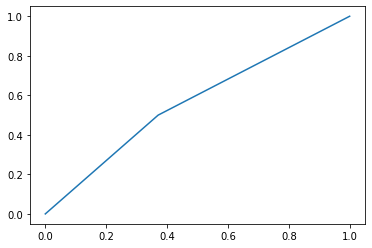

In [37]:
X.drop(b,inplace=True,axis=1)
X_train, X_test, y_train ,y_test =train_test_split(X,y,test_size=0.2,random_state=2)
model=LogisticRegression()
evaluationClassification(model)

* Data augmentation

<h1>Decision tree classifier</h1>

In [14]:
data_dtc=data.copy()

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [16]:
dtc=DecisionTreeClassifier()

In [17]:
X,y=preprocessing(data_dtc)
X_train, X_test, y_train ,y_test =train_test_split(X,y,test_size=0.2,stratify=y)

              precision    recall  f1-score   support

         0.0       0.92      0.91      0.92     56538
         1.0       0.13      0.15      0.14      4965

    accuracy                           0.85     61503
   macro avg       0.53      0.53      0.53     61503
weighted avg       0.86      0.85      0.86     61503

[[51599  4939]
 [ 4199   766]]
accuracy 0.8514218818594215
auc  0.5334613920065953
roc_auc_score  0.5334613920065953
f1 score :  0.14358013120899715


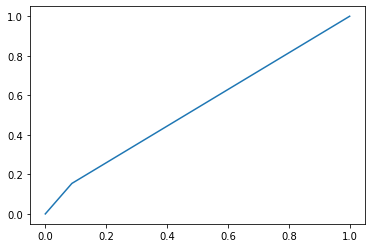

In [18]:
evaluationClassification(dtc)

[Text(459.07525492810817, 539.4818181818182, 'EXT_SOURCE <= 0.415\ngini = 0.149\nsamples = 246008\nvalue = [226102, 19906]\nclass = 0'),
 Text(142.96834550855996, 531.2454545454545, 'EXT_SOURCE <= 0.291\ngini = 0.305\nsamples = 47022\nvalue = [38195, 8827]\nclass = 0'),
 Text(36.28916393228662, 523.0090909090909, 'EXT_SOURCE <= 0.234\ngini = 0.417\nsamples = 7974\nvalue = [5613, 2361]\nclass = 0'),
 Text(15.047746979497946, 514.7727272727273, 'DAYS_BIRTH <= 33.5\ngini = 0.466\nsamples = 2635\nvalue = [1662, 973]\nclass = 0'),
 Text(4.91470905848024, 506.53636363636366, 'EXT_SOURCE <= 0.1\ngini = 0.441\nsamples = 1733\nvalue = [1165, 568]\nclass = 0'),
 Text(0.8360625239332254, 498.3, 'AMT_CREDIT <= 854325.0\ngini = 0.479\nsamples = 68\nvalue = [27, 41]\nclass = 1'),
 Text(0.7491988850830202, 490.06363636363636, 'AMT_CREDIT <= 222021.0\ngini = 0.46\nsamples = 64\nvalue = [23, 41]\nclass = 1'),
 Text(0.43431819425102625, 481.82727272727277, 'HOUR_APPR_PROCESS_START <= 14.0\ngini = 0.475\

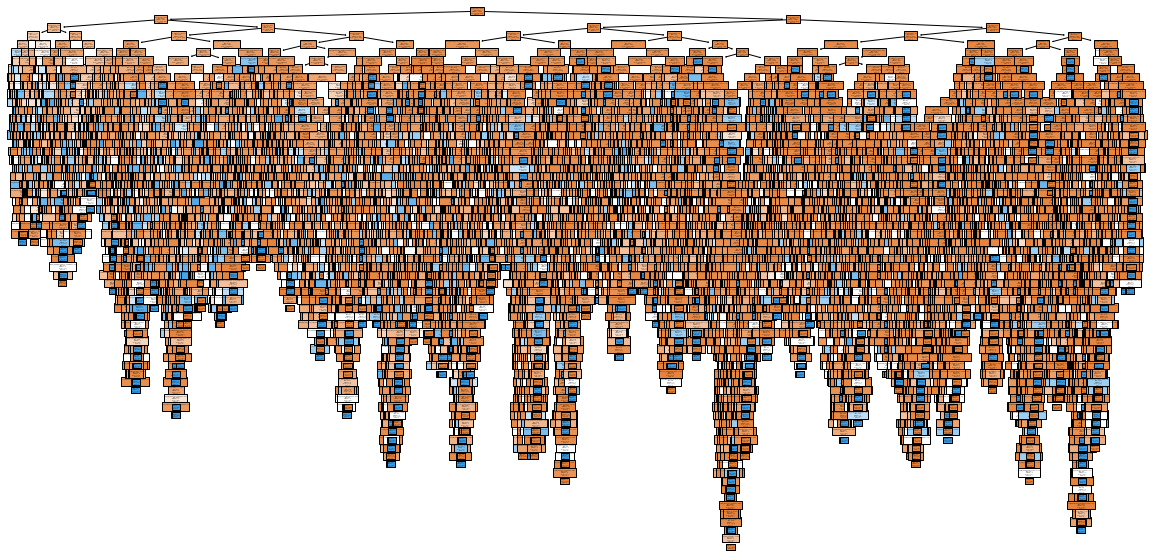

In [36]:
plt.figure(figsize=(20,10))
tree.plot_tree(dtc,feature_names=X_train.columns,filled=True,class_names=['0','1'])

In [ ]:
print(tree.export_text(dtc,feature_names=X_train.columns,class_names=['0','1']))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56538
         1.0       1.00      0.00      0.00      4965

    accuracy                           0.92     61503
   macro avg       0.96      0.50      0.48     61503
weighted avg       0.93      0.92      0.88     61503

[[56538     0]
 [ 4964     1]]
accuracy 0.9192884899923581
auc  0.5001007049345418
roc_auc_score  0.5001007049345418
f1 score :  0.00040273862263391055


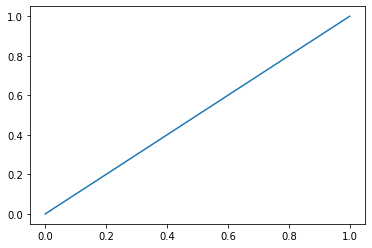

In [19]:
dtc=DecisionTreeClassifier(max_depth=5)
evaluationClassification(dtc)

[Text(558.0, 498.3, 'EXT_SOURCE <= 0.397\ngini = 0.149\nsamples = 246008\nvalue = [226132, 19876]\nclass = 0'),
 Text(279.0, 407.70000000000005, 'EXT_SOURCE <= 0.265\ngini = 0.297\nsamples = 54540\nvalue = [44657, 9883]\nclass = 0'),
 Text(139.5, 317.1, 'EXT_SOURCE <= 0.15\ngini = 0.377\nsamples = 16924\nvalue = [12656, 4268]\nclass = 0'),
 Text(69.75, 226.5, 'DAYS_BIRTH <= -18508.0\ngini = 0.433\nsamples = 4404\nvalue = [3006, 1398]\nclass = 0'),
 Text(34.875, 135.89999999999998, 'AMT_ANNUITY <= 20373.75\ngini = 0.339\nsamples = 1076\nvalue = [843, 233]\nclass = 0'),
 Text(17.4375, 45.299999999999955, 'gini = 0.274\nsamples = 543\nvalue = [454, 89]\nclass = 0'),
 Text(52.3125, 45.299999999999955, 'gini = 0.394\nsamples = 533\nvalue = [389, 144]\nclass = 0'),
 Text(104.625, 135.89999999999998, 'AMT_CREDIT <= 219456.0\ngini = 0.455\nsamples = 3328\nvalue = [2163, 1165]\nclass = 0'),
 Text(87.1875, 45.299999999999955, 'gini = 0.378\nsamples = 648\nvalue = [484, 164]\nclass = 0'),
 Text(1

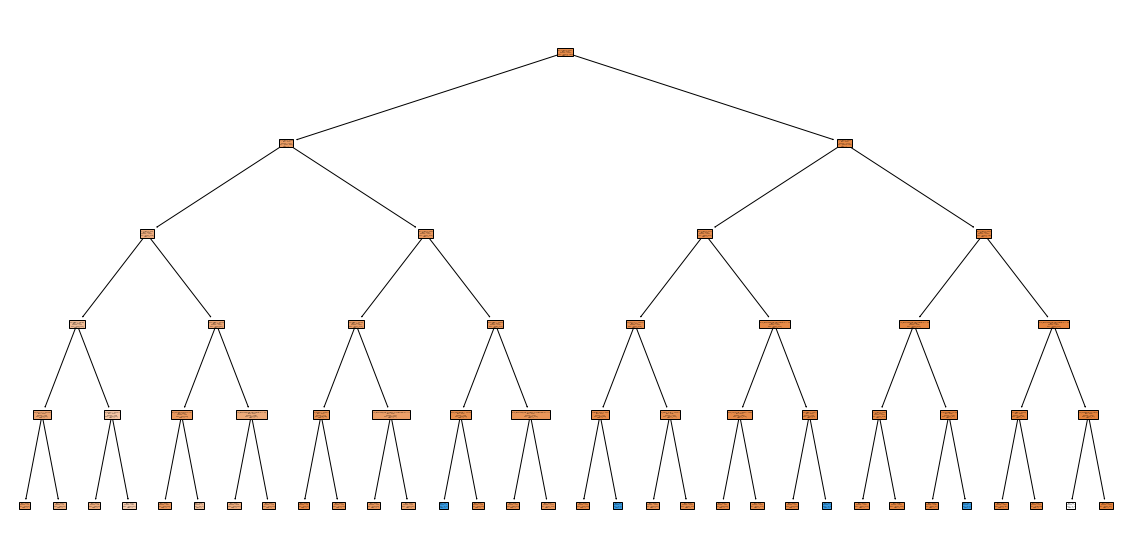

In [43]:
plt.figure(figsize=(20,10))
tree.plot_tree(dtc,feature_names=X_train.columns,filled=True,class_names=['0','1'])

In [44]:
# save_decision_trees_as_png(dtc, 5, X_train.columns, ["0","1"])

Decision Tree 6 saved as png file


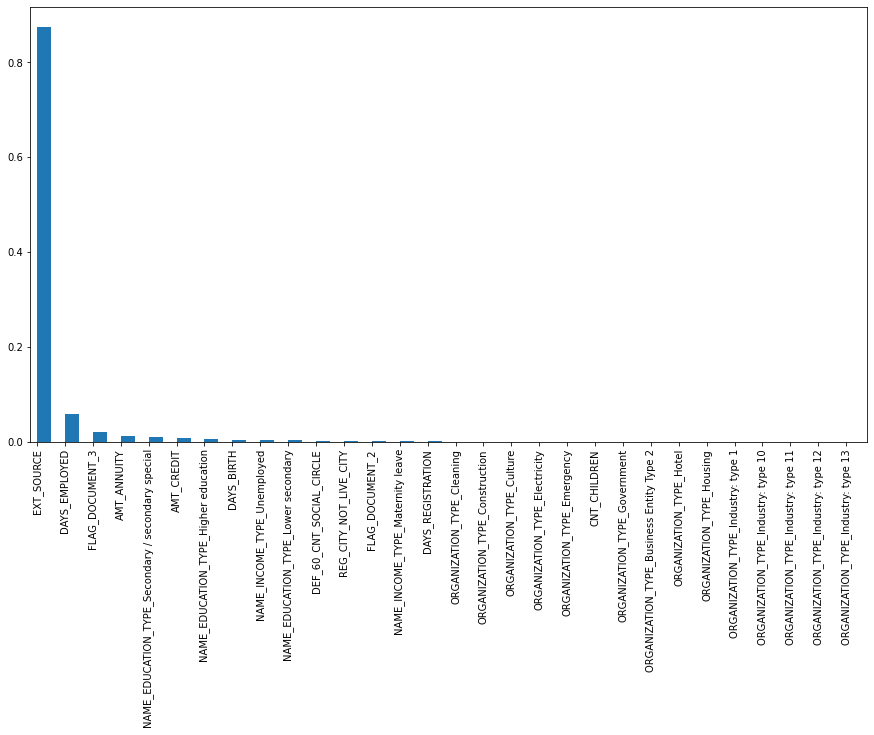

In [20]:
import pandas as pd
plt.figure(figsize=(15,8))
feature_importance= pd.Series(dtc.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(30)
feature_importance.plot(kind='bar',align='edge',orientation='vertical')
plt.show()

In [21]:
risque=data[data_dtc["TARGET"]==1]
non_risque=data[data_dtc["TARGET"]==0].sample(n=24825)

new=dd.concat([risque,non_risque]).compute()
X,y=preprocessing(new)
X_train, X_test, y_train ,y_test =train_test_split(X,y,test_size=0.2)

              precision    recall  f1-score   support

         0.0       0.66      0.64      0.65      4905
         1.0       0.66      0.68      0.67      5025

    accuracy                           0.66      9930
   macro avg       0.66      0.66      0.66      9930
weighted avg       0.66      0.66      0.66      9930

[[3147 1758]
 [1592 3433]]
accuracy 0.6626384692849949
auc  0.6623871468346341
roc_auc_score  0.6623871468346341
f1 score :  0.6720830070477681


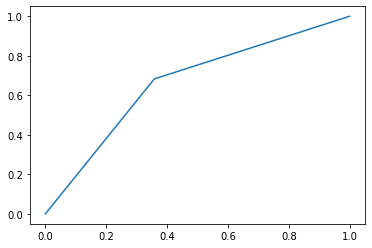

In [22]:
evaluationClassification(dtc)

* data augmentation

In [23]:
X,y=preprocessing(data_dtc)
X_train, X_test, y_train ,y_test =train_test_split(X,y,test_size=0.2)
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

              precision    recall  f1-score   support

         0.0       0.94      0.81      0.87     56435
         1.0       0.16      0.39      0.23      5068

    accuracy                           0.78     61503
   macro avg       0.55      0.60      0.55     61503
weighted avg       0.87      0.78      0.82     61503

[[45761 10674]
 [ 3067  2001]]
accuracy 0.776580004227436
auc  0.6028461807519095
roc_auc_score  0.6028461807519095
f1 score :  0.22555373950290256


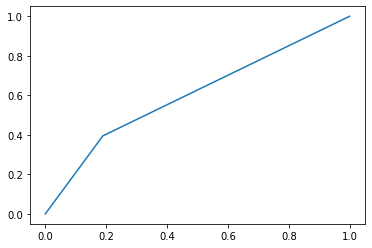

In [24]:
evaluationClassification(dtc)

* Pruning

In [88]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

In [299]:
dtc=DecisionTreeClassifier()
grid_params={'ccp_alpha':np.linspace(0.00001,0.0001,100)}
grid=GridSearchCV(dtc,grid_params,cv=5,n_jobs=6)
grid.fit(X_test,y_test)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=6,
             param_grid={'ccp_alpha': array([1.00000000e-05, 1.09090909e-05, 1.18181818e-05, 1.27272727e-05,
       1.36363636e-05, 1.45454545e-05, 1.54545455e-05, 1.63636364e-05,
       1.72727273e-05, 1.81818182e-05, 1.90909091e-05, 2.00000000e-05,
       2.09090909e-05, 2.18181818e-05, 2.27272727e-05, 2.36363636e-05,
       2.45454545e-05, 2....
       7.90909091e-05, 8.00000000e-05, 8.09090909e-05, 8.18181818e-05,
       8.27272727e-05, 8.36363636e-05, 8.45454545e-05, 8.54545455e-05,
       8.63636364e-05, 8.72727273e-05, 8.81818182e-05, 8.90909091e-05,
       9.00000000e-05, 9.09090909e-05, 9.18181818e-05, 9.27272727e-05,
       9.36363636e-05, 9.45454545e-05, 9.54545455e-05, 9.63636364e-05,
       9.72727273e-05, 9.81818182e-05, 9.90909091e-05, 1.00000000e-04])})

In [301]:
grid.best_params_

{'ccp_alpha': 9.636363636363637e-05}

In [283]:
grid.best_score_

0.9197274912542639

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56570
           1       0.00      0.00      0.00      4933

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503

[[56570     0]
 [ 4933     0]]
accuracy 0.9197925304456693
0.9197925304456693
auc  0.5


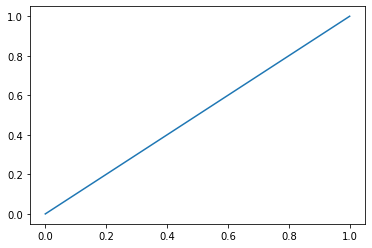

In [91]:
dtc=DecisionTreeClassifier(ccp_alpha=9.636363636363637e-05)
evaluationClassification(dtc)

In [92]:
dtc.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.03458967, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.0132324 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.95217792, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

[Text(643.8461538461538, 489.24, 'EXT_SOURCE <= 0.394\ngini = 0.149\nsamples = 246008\nvalue = [226116, 19892]\nclass = 0'),
 Text(429.23076923076917, 380.52000000000004, 'EXT_SOURCE <= 0.259\ngini = 0.3\nsamples = 53176\nvalue = [43420, 9756]\nclass = 0'),
 Text(257.53846153846155, 271.8, 'DAYS_EMPLOYED <= 8.5\ngini = 0.381\nsamples = 15799\nvalue = [11752, 4047]\nclass = 0'),
 Text(171.69230769230768, 163.08000000000004, 'EXT_SOURCE <= 0.178\ngini = 0.407\nsamples = 11702\nvalue = [8377, 3325]\nclass = 0'),
 Text(85.84615384615384, 54.360000000000014, 'gini = 0.441\nsamples = 4711\nvalue = [3165, 1546]\nclass = 0'),
 Text(257.53846153846155, 54.360000000000014, 'gini = 0.379\nsamples = 6991\nvalue = [5212, 1779]\nclass = 0'),
 Text(343.38461538461536, 163.08000000000004, 'gini = 0.29\nsamples = 4097\nvalue = [3375, 722]\nclass = 0'),
 Text(600.9230769230769, 271.8, 'EXT_SOURCE <= 0.332\ngini = 0.259\nsamples = 37377\nvalue = [31668, 5709]\nclass = 0'),
 Text(515.0769230769231, 163.08

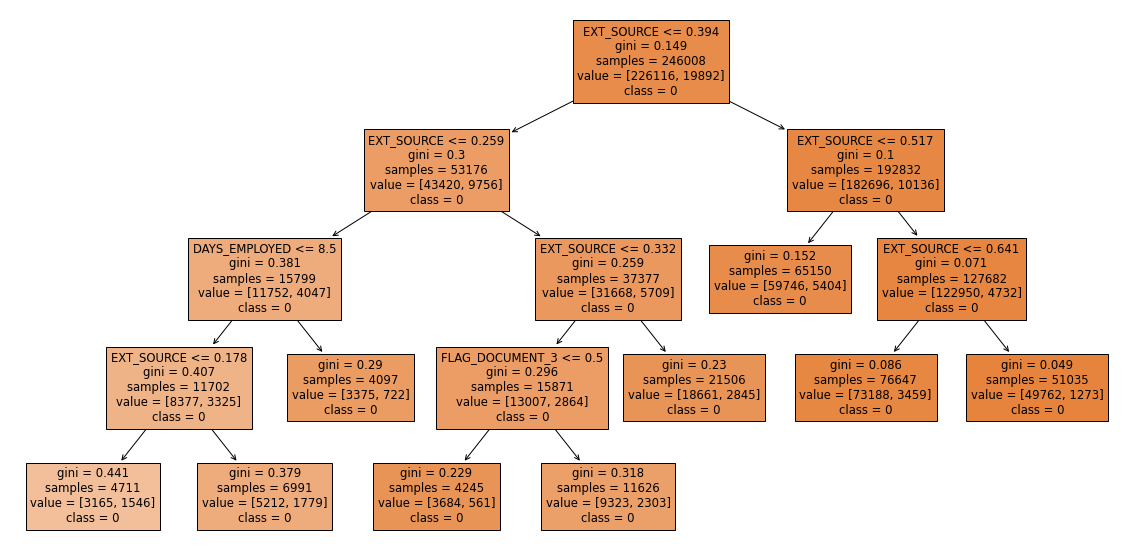

In [93]:
plt.figure(figsize=(20,10))
tree.plot_tree(dtc,feature_names=X_train.columns,filled=True,class_names=['0','1'])

* On peut rien conclure abscence de la classe 1 dans l'arbre ==> decisions commerciales impossible

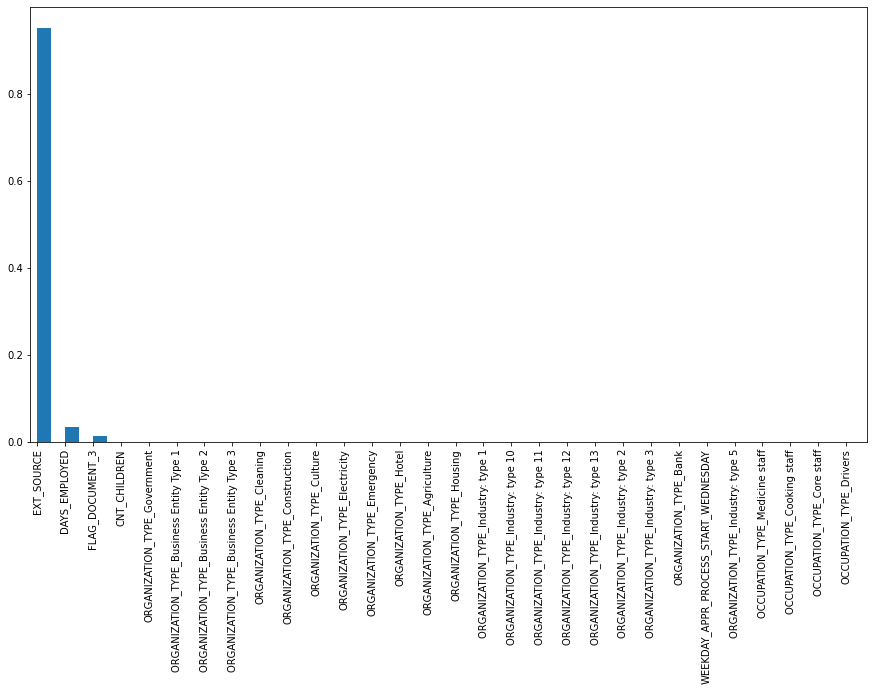

In [94]:
import pandas as pd
plt.figure(figsize=(15,8))
feature_importance= pd.Series(dtc.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(30)
feature_importance.plot(kind='bar',align='edge',orientation='vertical')
plt.show()

<h1>Random Forest Classifier </h1>

In [25]:
data_rfc=data.copy()

In [26]:
from sklearn.ensemble import RandomForestClassifier

              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95     56435
         1.0       0.29      0.04      0.07      5068

    accuracy                           0.91     61503
   macro avg       0.61      0.51      0.51     61503
weighted avg       0.87      0.91      0.88     61503

[[55982   453]
 [ 4879   189]]
accuracy 0.91330504203047
auc  0.5146329420195433
roc_auc_score  0.5146329420195433
f1 score :  0.06619964973730298


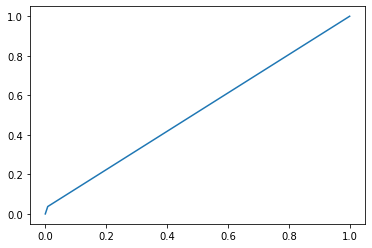

In [27]:
rfc=RandomForestClassifier()
evaluationClassification(rfc)

In [28]:
risque=data[data_rfc["TARGET"]==1]
non_risque=data[data_rfc["TARGET"]==0].sample(n=24825)

new=dd.concat([risque,non_risque]).compute()
X,y=preprocessing(new)
X_train, X_test, y_train ,y_test =train_test_split(X,y,test_size=0.2)

* equilibre manuelle

              precision    recall  f1-score   support

         0.0       0.66      0.69      0.68      4947
         1.0       0.68      0.65      0.66      4983

    accuracy                           0.67      9930
   macro avg       0.67      0.67      0.67      9930
weighted avg       0.67      0.67      0.67      9930

[[3429 1518]
 [1755 3228]]
accuracy 0.670392749244713
auc  0.6704749453174146
roc_auc_score  0.6704749453174146
f1 score :  0.6635831020659883


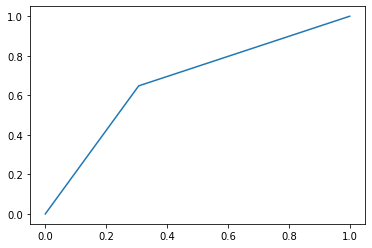

In [29]:
rfc=RandomForestClassifier()
evaluationClassification(rfc)

* data augmentation

In [30]:
X,y=preprocessing(data_rfc)
X_train, X_test, y_train ,y_test =train_test_split(X,y,test_size=0.2)
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96     56580
         1.0       0.29      0.04      0.06      4923

    accuracy                           0.92     61503
   macro avg       0.61      0.51      0.51     61503
weighted avg       0.87      0.92      0.88     61503

[[56162   418]
 [ 4750   173]]
accuracy 0.915971578622181
auc  0.5138767022754879
roc_auc_score  0.5138767022754879
f1 score :  0.0627493652520856


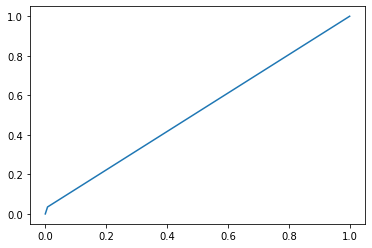

In [31]:
rfc=RandomForestClassifier()
evaluationClassification(rfc)

In [290]:
rfc=RandomForestClassifier()
param_grid = { 
    'n_estimators': [100,200,500],
    'max_depth' : [4,5,6,7]
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5,n_jobs=-1)
CV_rfc.fit(X_test, y_test)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6, 7],
                         'n_estimators': [100, 200, 500]})

In [292]:
CV_rfc.best_params_

{'max_depth': 4, 'n_estimators': 100}

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56570
           1       0.00      0.00      0.00      4933

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503

[[56570     0]
 [ 4933     0]]
accuracy 0.9197925304456693
0.9197925304456693
auc  0.5


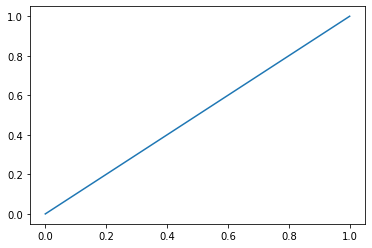

In [101]:
rfc=RandomForestClassifier(random_state=42, n_estimators= 100, max_depth=4)
evaluationClassification(rfc)

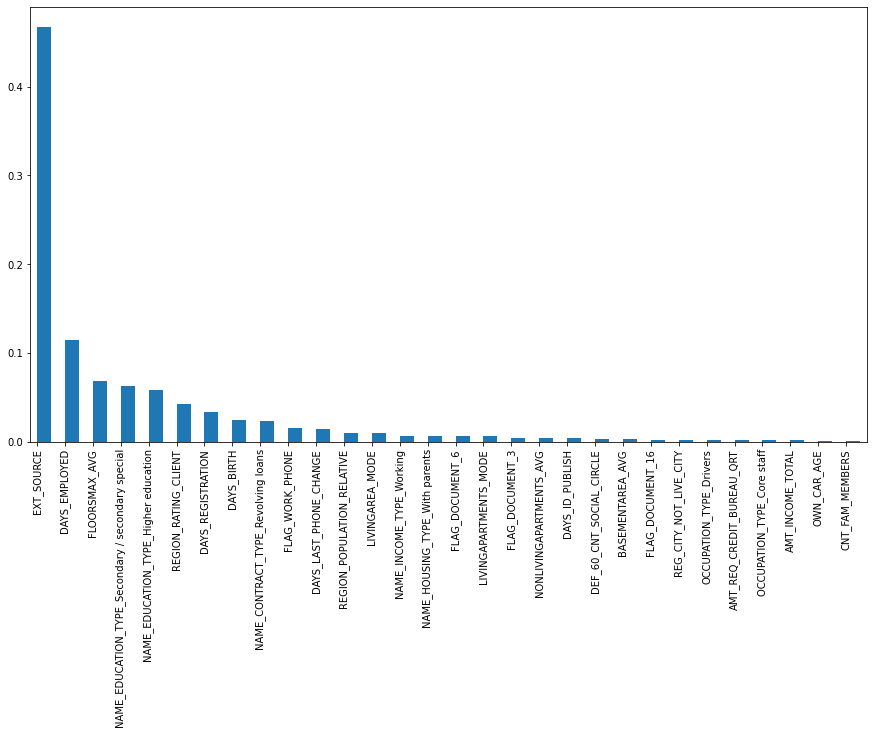

In [100]:
import pandas as pd
plt.figure(figsize=(15,8))
feature_importance= pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(30)
feature_importance.plot(kind='bar',align='edge',orientation='vertical')
plt.show()

In [40]:
from sklearn.tree import export_graphviz
import pydotplus
def save_decision_trees_as_png(rfc, iteration, feature_name, target_name):
    file_name = "risk" + str(iteration) + ".png"
    dot_data = export_graphviz(
        rfc,
        out_file=None,
        feature_names=feature_name,
        class_names=target_name,
        rounded=True,
        proportion=False,
        precision=2,
        filled=True,
    )
    graph = pydotplus.graph_from_dot_data(dot_data)
    graph.write_png(file_name)
    print("Decision Tree {} saved as png file".format(iteration + 1))

In [ ]:
for i in range(len(rfc.estimators_)):
    save_decision_trees_as_png(rfc.estimators_[i], i, X_train.columns, ["0","1"])

* RandomForestClassifier est mieux que DecisionTree au niveau du dressage de l'arbre de decision 
* DecisionTree est plus précis au niveau du prédicition

<h1>TPOT</h1>

In [15]:
from tpot import TPOTClassifier

In [9]:
X,y=preprocessing(data)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.80, test_size=0.20, random_state=42)

tpot = TPOTClassifier(generations=5,verbosity=2)
tpot.fit(X_train, y_train)

                                                                                    
                                                                                    
TPOT closed during evaluation in one generation.
                                                                                    
                                                                                    
TPOT closed prematurely. Will use the current best pipeline.
                                                                                    
Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=0.001, max_depth=1, max_features=0.9000000000000001, min_samples_leaf=11, min_samples_split=11, n_estimators=100, subsample=0.3)


TPOTClassifier(generations=5, verbosity=2)

In [12]:
print(tpot.score(X_test, y_test))
tpot.export('tpot_digits_pipeline.py')

0.9195323805342829


<h1>Gradient Boosting Classifier</h1>

In [32]:
from sklearn.ensemble import GradientBoostingClassifier

In [35]:
exported_pipeline = GradientBoostingClassifier(learning_rate=0.001, max_depth=1, max_features=0.9000000000000001, min_samples_leaf=11, min_samples_split=11, n_estimators=100, subsample=0.3)

In [33]:
X,y=preprocessing(data)
X_train, X_test, y_train ,y_test =train_test_split(X,y,test_size=0.2,random_state=2)

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56550
         1.0       0.00      0.00      0.00      4953

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503

[[56550     0]
 [ 4953     0]]
accuracy 0.9194673430564363
auc  0.5
roc_auc_score  0.5
f1 score :  0.0


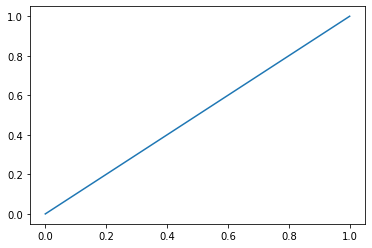

In [36]:
evaluationClassification(exported_pipeline)

In [37]:
risque=data[data["TARGET"]==1]
non_risque=data[data["TARGET"]==0].sample(n=24825)

new=dd.concat([risque,non_risque]).compute()
X,y=preprocessing(new)
X_train, X_test, y_train ,y_test =train_test_split(X,y,test_size=0.2)

              precision    recall  f1-score   support

         0.0       0.65      0.70      0.67      4918
         1.0       0.68      0.63      0.65      5012

    accuracy                           0.66      9930
   macro avg       0.66      0.66      0.66      9930
weighted avg       0.66      0.66      0.66      9930

[[3422 1496]
 [1845 3167]]
accuracy 0.6635448136958711
auc  0.6638473925287727
roc_auc_score  0.6638473925287727
f1 score :  0.6546770025839793


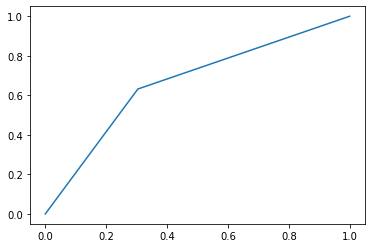

In [38]:
evaluationClassification(exported_pipeline)

In [19]:
tpot = TPOTClassifier(generations=1,verbosity=2)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('tpot_digits_pipeline.py')

                                                                                
                                                                                
TPOT closed during evaluation in one generation.
                                                                                
                                                                                
TPOT closed prematurely. Will use the current best pipeline.


: 

<h1>Bagging</h1>

In [39]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier 

In [ ]:
X,y=preprocessing(data)
X_train, X_test, y_train ,y_test =train_test_split(X,y,test_size=0.2)
model = BaggingClassifier(base_estimator=RandomForestClassifier())
evaluationClassification(model)

In [40]:
X,y=preprocessing(data)
X_train, X_test, y_train ,y_test =train_test_split(X,y,test_size=0.2)

In [41]:
classifier = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='not majority',
                                replacement=False,
                                random_state=42)

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56591
         1.0       0.27      0.02      0.04      4912

    accuracy                           0.92     61503
   macro avg       0.59      0.51      0.50     61503
weighted avg       0.87      0.92      0.88     61503

[[56324   267]
 [ 4814    98]]
accuracy 0.9173861437653448
auc  0.5076165376776052
roc_auc_score  0.5076165376776052
f1 score :  0.03714231570968352


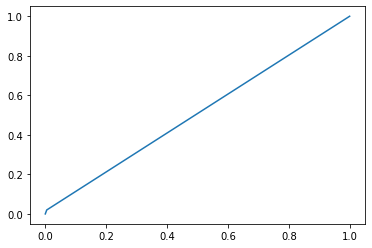

In [42]:
evaluationClassification(classifier)

<h1>Threshold moving</h1>

In [43]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train,y_train)   
rf_model.predict_proba(X_test)

array([[0.77, 0.23],
       [0.98, 0.02],
       [0.85, 0.15],
       ...,
       [0.97, 0.03],
       [0.94, 0.06],
       [0.89, 0.11]])

In [44]:
step_factor = 0.05 
threshold_value = 0.2 
roc_score=0
predicted_proba = rf_model.predict_proba(X_test)
while threshold_value <=0.8: 
    temp_thresh = threshold_value
    predicted = (predicted_proba [:,1] >= temp_thresh).astype('int') 
    print('Threshold',temp_thresh,'--',roc_auc_score(y_test, predicted))
    if roc_score<roc_auc_score(y_test, predicted): 
        roc_score = roc_auc_score(y_test, predicted)
        thrsh_score = threshold_value
    threshold_value = threshold_value + step_factor
print('---Optimum Threshold ---',thrsh_score,'--ROC--',roc_score)

Threshold 0.2 -- 0.583942860586538
Threshold 0.25 -- 0.5476490831232761
Threshold 0.3 -- 0.5221464346692022
Threshold 0.35 -- 0.5100227109638698
Threshold 0.39999999999999997 -- 0.5032227287553982
Threshold 0.44999999999999996 -- 0.5006906376671466
Threshold 0.49999999999999994 -- 0.5001770770803728
Threshold 0.5499999999999999 -- 0.5
Threshold 0.6 -- 0.5
Threshold 0.65 -- 0.5
Threshold 0.7000000000000001 -- 0.5
Threshold 0.7500000000000001 -- 0.5
---Optimum Threshold --- 0.2 --ROC-- 0.583942860586538


              precision    recall  f1-score   support

         0.0       0.93      0.94      0.94     56591
         1.0       0.25      0.24      0.24      4912

    accuracy                           0.88     61503
   macro avg       0.59      0.59      0.59     61503
weighted avg       0.88      0.88      0.88     61503

[[53046  3545]
 [ 3753  1159]]
accuracy 0.8813391216688616
auc  0.5866551495394953
roc_auc_score  0.5866551495394953
f1 score :  0.24105657237936767


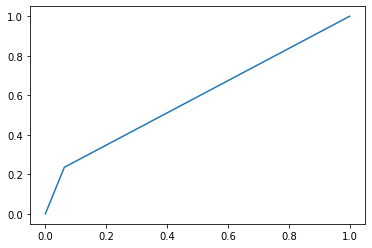

In [45]:
evaluationClassificationThreshold(RandomForestClassifier(),0.2)

In [46]:
rf_model = DecisionTreeClassifier()
rf_model.fit(X_train,y_train)   
rf_model.predict_proba(X_test)
BestThreshold(rf_model)

Threshold 0.2 -- 0.5384289371613687
Threshold 0.25 -- 0.5384289371613687
Threshold 0.3 -- 0.5384289371613687
Threshold 0.35 -- 0.5384289371613687
Threshold 0.39999999999999997 -- 0.5384289371613687
Threshold 0.44999999999999996 -- 0.5384289371613687
Threshold 0.49999999999999994 -- 0.5384289371613687
Threshold 0.5499999999999999 -- 0.5384289371613687
Threshold 0.6 -- 0.5384289371613687
Threshold 0.65 -- 0.5384289371613687
Threshold 0.7000000000000001 -- 0.5384289371613687
Threshold 0.7500000000000001 -- 0.5384289371613687
---Optimum Threshold --- 0.2 --ROC-- 0.5384289371613687


              precision    recall  f1-score   support

         0.0       0.93      0.91      0.92     56591
         1.0       0.13      0.16      0.14      4912

    accuracy                           0.85     61503
   macro avg       0.53      0.53      0.53     61503
weighted avg       0.86      0.85      0.86     61503

[[51624  4967]
 [ 4143   769]]
accuracy 0.8518771442043478
auc  0.5343926172322724
roc_auc_score  0.5343926172322724
f1 score :  0.14444027047332833


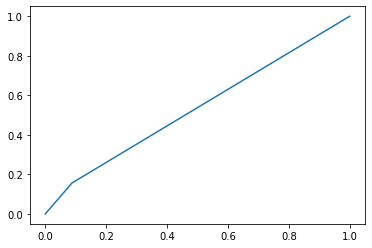

In [47]:
evaluationClassificationThreshold(DecisionTreeClassifier(),0.2)